In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = ['Linux Libertine']
import numpy as np

On se propose de résoudre un problème aux limites de Dirichlet
$$
\begin{cases}
-u'' + \lambda u =f & \text{dans }(0,L) \\
u(0) = u(L) = 0
\end{cases}
$$

Sa formulation variationnelle est
$$\forall \phi\in V_0,\quad
\int_0^L u'(x)\phi'(x) dx + \lambda\int_0^L u(x)\phi(x) = \int_0^L f(x)\phi(x) dx
$$
où $V_0 := \{v\in\mathcal C^1(0,L)\,\mid\, \phi(0)=\phi(L)=0\} $ une fonction test.

In [3]:
L = 1
N = 100
dx = L/N
xrange = np.linspace(0,L,N+1)

In [4]:
def phi(x,n=None):
    if n is None:
        return np.maximum(0,1 - np.absolute(x))
    else:
        return phi((x-xrange[n])/dx)

Donc, avec une solution $u= \sum_{i=0}^N u_i\phi_i(x)$,
$$\forall j\in\{0,\ldots,N\}\quad
\sum_{i=0}^N u_i (\phi_i'\phi_j' + \lambda \phi_i\phi_j)dx = \int_0^L f(x)\phi_j(x) dx
$$

On note $\phi(x) = \max(0,1-|x|)$ et
$$
\phi_i(x) = \phi\left(\frac{x-x_i}{h}\right).
$$

La matrice de rigidité $\mathcal K_h$ est une matrice de Toeplitz:

In [5]:
from scipy import linalg
rigid = (1/dx)*linalg.toeplitz([2,-1] + [0 for _ in range(N-1)])

La matrice de masse $\mathcal M_h$ est aussi tridiagonale:

In [6]:
masse = dx*linalg.toeplitz([2/3,1/6] + [0 for _ in range(N-1)])

On définit la fonction $f$

In [7]:
def quad_trapz(g,a,b,p):
    step = (b-a)/(p+1)
    first_term = 0.5*step*(g(a)+g(b))
    second_term = step*np.sum(g(a+k*step) for k in range(1,p))
    return first_term + second_term
    

In [8]:
def coeffs_from_f(f):
    res = []
    
    p = 5
    res.append(quad_trapz(lambda x: f(x)*phi(x,0),xrange[0],xrange[1],p))
    for n in range(1,N):    
        res.append(
            quad_trapz(lambda x: f(x)*phi(x,n),xrange[n-1],xrange[n+1],p)
        )
    res.append(quad_trapz(lambda x: f(x)*phi(x,N),xrange[N-1],xrange[N],p))
    return np.array(res)

In [12]:
def make_f():
    import sympy as sp
    from sympy.abc import x
    return sp.lambdify(x, (1-x)*x*1/(1+x**2)*sp.cos(10*x),["numpy"])

f = make_f()
coeffsF = coeffs_from_f(f)

Pour obtenir le vecteur $U = (u_h(x_i))_{0\leq i\leq N}$, il faut résoudre le système linéaire
$$
\mathcal K_h U + \lambda \mathcal M_h U = b
$$
où $$
b_i = \int_0^L \phi_i(x)f(x)\,dx
$$

In [13]:
def recon_f(x):
    return np.sum(phi(x,n)*f(xrange[n]) for n in range(N+1))

xPlotRange = xrange

def graphe(lmda):
    fig = plt.figure(0,figsize=(5,6))
    ax0 = fig.add_subplot(211)
    ax1 = fig.add_subplot(212)
    ax0.grid(True)
    ax1.grid(True)
    
    coeffsU = np.linalg.solve(rigid + lmda*masse,coeffsF)
    
    def u(x):
        return np.sum(phi(x,n)*coeffsU[n] for n in range(N+1))
    
    ax0.plot(xPlotRange,u(xPlotRange),'r',label="$u(x)$")
    #ax.plot(xPlotRange,f(xPlotRange),'b',label=r'$f$')
    ax1.plot(xPlotRange,(lambda x: f(x)*phi(x,2))(xPlotRange),
                       label=r"$f(x)\phi_{2}(x)$")
    ax1.plot(xPlotRange,recon_f(xPlotRange),'g',label=r"Approximation $\mathrm{\mathbb{P}}_1$ de $f$")
    ax0.legend()
    ax1.legend()
    """for i in [10,20,30,50,70]:
        ax.plot(xPlotRange,phi(xPlotRange,i))
    """

<IPython.core.display.Javascript object>


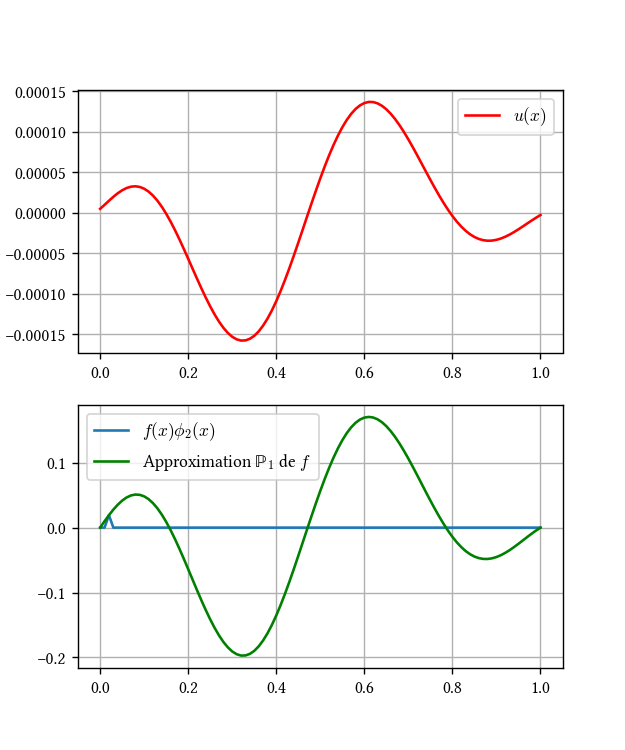

In [15]:
lmda = 1000
graphe(lmda)